In [15]:
# import needed packages
using DelimitedFiles
using Random
using Flux
using Flux: Data.DataLoader, @epochs, train!, mse, normalise, mae
using Plots
using BSON: @save, @load
using Statistics

In [16]:
# read-in the data
data = readdlm("airfoil_self_noise.dat")

# shuffle the data
n = size(data,1)
permutation = randperm(n)
data = data[permutation,:]

# divide the data into training and testing sets
train_data = data[1:n-150,:]
test_data = data[n-149:n,:]

150×6 Matrix{Float64}:
  2000.0   4.0  0.2286  31.7  0.00509068  122.089
  6300.0   1.5  0.3048  39.6  0.00392107  114.751
  2500.0   0.0  0.0254  55.5  0.00041229  130.073
  6300.0  12.6  0.1524  71.3  0.0483159   107.284
  1600.0   0.0  0.3048  55.5  0.00283081  126.986
  4000.0  15.4  0.0508  31.7  0.0289853   115.635
  2500.0   7.2  0.1524  71.3  0.00752039  124.353
  5000.0  12.6  0.1524  39.6  0.0584113   104.13
   630.0  12.7  0.0254  71.3  0.0121808   128.878
   315.0  22.2  0.0254  39.6  0.0229028   120.716
   400.0   5.4  0.1524  39.6  0.00485029  127.637
  1250.0   4.2  0.0508  39.6  0.00152689  128.427
  1600.0   0.0  0.1016  55.5  0.00131983  132.05
     ⋮                                      ⋮
  2000.0  12.7  0.0254  39.6  0.0130253   129.567
  3150.0   4.0  0.2286  31.7  0.00509068  120.229
 16000.0   0.0  0.2286  71.3  0.00214345  114.984
  5000.0   5.4  0.1524  31.7  0.00525474  115.691
   630.0   0.0  0.1016  39.6  0.00146332  125.401
  1600.0   5.3  0.2286  39.6  0.0

In [17]:
# normalize the input (use this cell or the following, but not both!)
train_data = permutedims(train_data)
test_data = permutedims(test_data)

train_data[1:5,:] = normalise(train_data[1:5,:])
test_data[1:5,:] = normalise(test_data[1:5,:])

5×150 Matrix{Float64}:
 -0.27691    0.99617   -0.128877  …  -0.498958  -0.750614   3.868
 -0.456041  -0.857958  -1.09911       0.428175  -0.230968  -0.857958
  0.985506   1.80981   -1.21265      -1.21265    0.161198   1.80981
 -1.17662   -0.664767   0.365427      1.38914   -1.17662    1.38914
 -0.464398  -0.567253  -0.875813     -0.542149  -0.449971  -0.615952

In [3]:
# normalize the data
maxima = [maximum(train_data[:,i]) for i in 1:6]
minima = [minimum(train_data[:,i]) for i in 1:6]

for i in 1:n-150
    train_data[i,:] .-= minima 
    train_data[i,:] ./= maxima - minima
end

for i in 1:150
    test_data[i,:] .-= minima
    test_data[i,:] ./= maxima - minima
end

train_data = permutedims(train_data)
test_data = permutedims(test_data)

# train_data[6,:] = train_data[6,:] * (maxima[6]-minima[6]) .+ minima[6]

6×150 Matrix{Float64}:
 0.0530303  0.621212    0.116162   …  0.030303  0.0707071  0.0151515
 0.427928   0.0         0.0           0.400901  0.135135   0.0900901
 0.0        0.0909091   0.454545      0.272727  1.0        0.727273
 0.0        0.0         0.0           1.0       0.0        0.0
 0.0726262  0.00709322  0.0291907     0.170798  0.0843718  0.0572831
 0.746297   0.41721     0.597947   …  0.915601  0.497461   0.619486

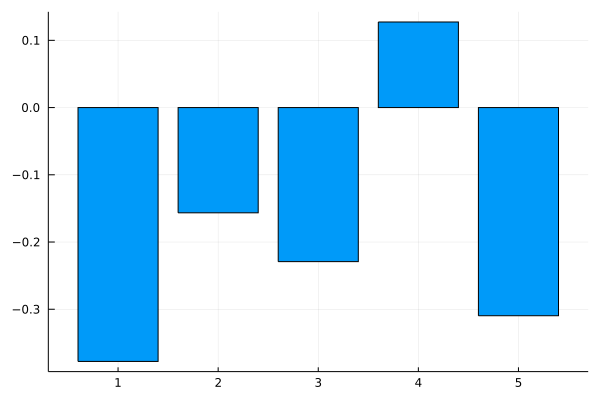

In [18]:
correlations = [cor(train_data[i,:], train_data[6,:]) for i in 1:5]
bar(correlations, legend=false)

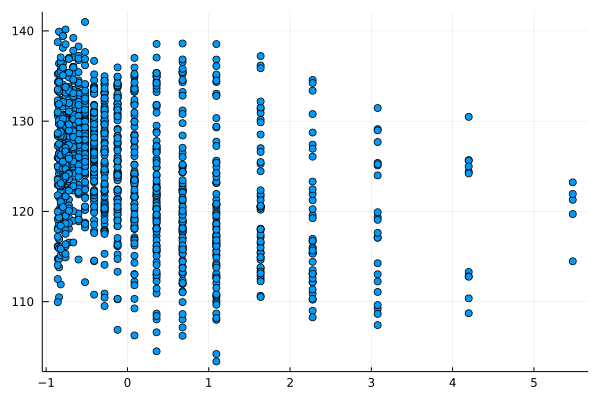

In [19]:
scatter(train_data[1,:], train_data[6,:], legend=false)

In [67]:
# define the model
model = Chain(Dense(5, 5, relu), Dense(5, 3, relu), Dense(3, 1, relu))

# define parameters and cost function
parameters = params(model)
loss(x, y) = mse(model(x), y)

loss (generic function with 1 method)

In [75]:
# set optimization algorithm
η = 0.002
optimizer = Descent(η)

Descent(0.002)

In [56]:
# define data loader
n = size(train_data,2)
loader = DataLoader((train_data[1:5,:], permutedims(train_data[6,:])), batchsize=n)

DataLoader{Tuple{Matrix{Float64}, Matrix{Float64}}, Random._GLOBAL_RNG}(([0.35804765551574774 -0.7618082771521519 … 0.6780064934208619 -0.6018288581995948; 0.9391751136897862 -0.4720380378335594 … -0.43803290165227393 0.9391751136897862; … ; -0.7299654266803766 1.304903521308628 … -0.7299654266803766 1.304903521308628; 2.219643785823499 -0.4684470380819648 … -0.7272032997859904 1.6911896616145266], [110.905 130.715 … 129.777 127.928]), 1353, 1353, true, 1353, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353], false, Random._GLOBAL_RNG())

In [76]:
@epochs 30000 train!(loss, parameters, loader, optimizer)

┌ Info: Epoch 1
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 6
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 7
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 8
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 9
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 10
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 11
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:1

┌ Info: Epoch 179
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 180
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 181
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 182
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 183
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 184
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 185
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 186
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 187
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 188
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 189
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 357
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 358
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 359
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 360
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 361
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 362
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 363
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 364
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 365
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 366
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 367
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 463
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 464
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 465
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 466
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 467
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 468
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 469
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 470
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 471
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 472
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 473
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 571
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 572
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 573
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 574
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 575
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 576
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 577
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 578
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 579
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 580
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 581
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 677
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 678
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 679
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 680
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 681
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 682
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 683
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 684
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 685
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 686
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 687
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 819
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 820
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 821
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 822
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 823
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 824
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 825
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 826
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 827
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 828
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 829
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 925
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 926
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 927
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 928
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 929
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 930
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 931
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 932
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 933
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 934
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 935
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src

┌ Info: Epoch 1045
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1046
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1047
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1048
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1049
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1050
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1051
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1052
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1053
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1054
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1055
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1151
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1152
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1153
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1154
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1155
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1156
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1157
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1158
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1159
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1160
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1161
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1295
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1296
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1297
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1298
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1299
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1300
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1301
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1302
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1303
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1304
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1305
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1401
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1402
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1403
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1404
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1405
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1406
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1407
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1408
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1409
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1410
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1411
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1507
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1508
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1509
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1510
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1511
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1512
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1513
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1514
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1515
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1516
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1517
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1613
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1614
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1615
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1616
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1617
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1618
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1619
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1620
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1621
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1622
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1623
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1755
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1756
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1757
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1758
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1759
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1760
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1761
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1762
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1763
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1764
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1765
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1861
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1862
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1863
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1864
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1865
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1866
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1867
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1868
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1869
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1870
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1871
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 1969
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1970
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1971
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1972
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1973
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1974
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1975
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1976
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1977
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1978
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 1979
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2075
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2076
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2077
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2078
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2079
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2080
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2081
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2082
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2083
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2084
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2085
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2185
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2186
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2187
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2188
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2189
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2190
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2191
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2192
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2193
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2194
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2195
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2375
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2376
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2377
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2378
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2379
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2380
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2381
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2382
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2383
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2384
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2385
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2481
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2482
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2483
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2484
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2485
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2486
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2487
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2488
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2489
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2490
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2491
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2589
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2590
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2591
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2592
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2593
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2594
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2595
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2596
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2597
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2598
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2599
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2765
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2766
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2767
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2768
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2769
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2770
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2771
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2772
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2773
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2774
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2775
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 2887
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2888
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2889
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2890
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2891
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2892
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2893
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2894
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2895
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2896
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 2897
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3019
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3020
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3021
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3022
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3023
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3024
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3025
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3026
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3027
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3028
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3029
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3125
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3126
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3127
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3128
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3129
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3130
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3131
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3132
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3133
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3134
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3135
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3253
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3254
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3255
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3256
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3257
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3258
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3259
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3260
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3261
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3262
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3263
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3359
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3360
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3361
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3362
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3363
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3364
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3365
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3366
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3367
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3368
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3369
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3481
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3482
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3483
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3484
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3485
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3486
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3487
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3488
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3489
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3490
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3491
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3587
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3588
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3589
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3590
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3591
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3592
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3593
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3594
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3595
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3596
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3597
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3697
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3698
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3699
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3700
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3701
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3702
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3703
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3704
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3705
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3706
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3707
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3833
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3834
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3835
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3836
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3837
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3838
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3839
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3840
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3841
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3842
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3843
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 3997
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3998
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 3999
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4000
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4001
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4002
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4003
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4004
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4005
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4006
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4007
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4103
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4104
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4105
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4106
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4107
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4108
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4109
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4110
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4111
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4112
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4113
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4229
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4230
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4231
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4232
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4233
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4234
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4235
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4236
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4237
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4238
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4239
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4335
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4336
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4337
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4338
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4339
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4340
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4341
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4342
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4343
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4344
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4345
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4483
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4484
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4485
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4486
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4487
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4488
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4489
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4490
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4491
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4492
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4493
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4589
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4590
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4591
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4592
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4593
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4594
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4595
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4596
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4597
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4598
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4599
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4723
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4724
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4725
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4726
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4727
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4728
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4729
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4730
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4731
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4732
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4733
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4829
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4830
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4831
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4832
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4833
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4834
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4835
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4836
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4837
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4838
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4839
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 4959
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4960
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4961
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4962
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4963
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4964
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4965
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4966
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4967
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4968
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 4969
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 5065
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5066
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5067
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5068
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5069
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5070
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5071
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5072
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5073
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5074
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5075
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 5203
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5204
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5205
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5206
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5207
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5208
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5209
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5210
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5211
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5212
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5213
└ @ Main /home/hassan/.julia/packages/Flu

┌ Info: Epoch 5331
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5332
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5333
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5334
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5335
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5336
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5337
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5338
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5339
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5340
└ @ Main /home/hassan/.julia/packages/Flux/6o4DQ/src/optimise/train.jl:135
┌ Info: Epoch 5341
└ @ Main /home/hassan/.julia/packages/Flu

In [919]:
i = 53
(model(train_data[1:5,i]), train_data[6,i])

([0.0], 115.413)

In [77]:
total = 0.0
for i in 1:size(train_data,2)
    total += mse(model(train_data[1:5,i]),train_data[6,i])
end
total/size(train_data,2)

8.459217022111176

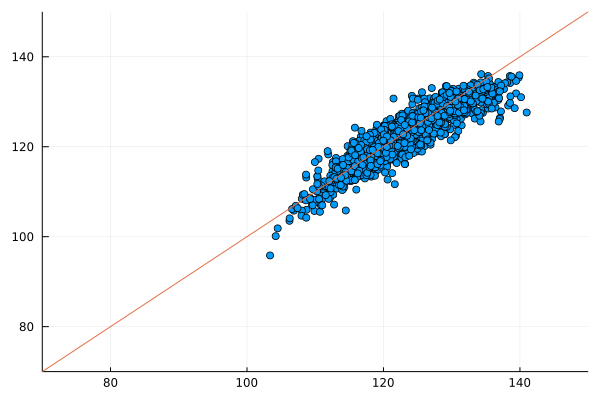

In [78]:
predictions = [model(train_data[1:5,i])[1] for i in 1:n]
scatter(train_data[6,:], predictions, legend=false, xlims=(70,150), ylims=(70,150))
plot!(x -> x)

In [168]:
total = 0.0
for i in 1:size(balanced,2)
    total += mse(model(balanced[1:5,i]),balanced[6,i])
end
total/size(balanced,2)

15424.845364391222

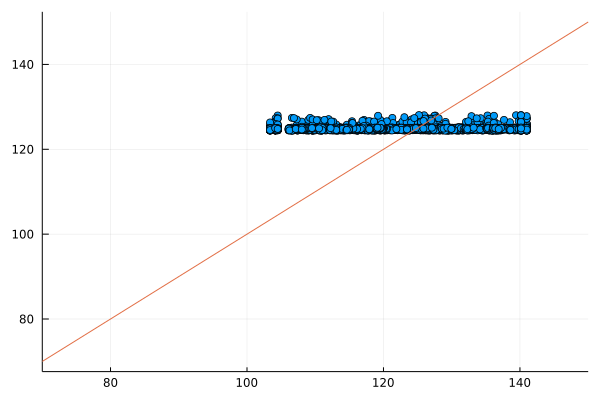

In [186]:
predictions = [model(balanced[1:5,i])[1] for i in 1:n-150]
scatter(balanced[6,:], predictions, legend=false, xlims=(70,150)#=, ylims=(70,150)=#)
plot!(x -> x)

In [79]:
total = 0.0
for i in 1:size(test_data,2)
    total += mse(model(test_data[1:5,i]),test_data[6,i])
end
total/size(test_data,2)

7.3504416842667855

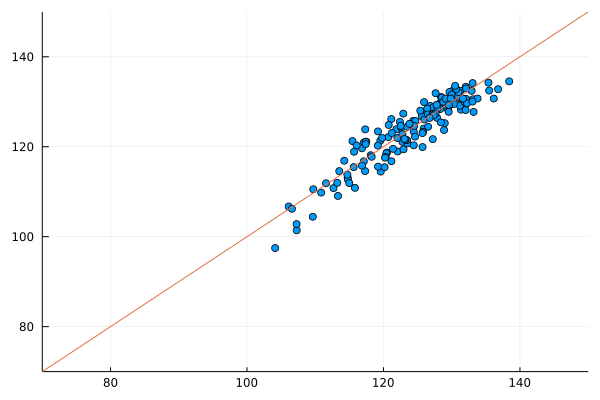

In [81]:
predictions = [model(test_data[1:5,i])[1] for i in 1:150]
scatter(test_data[6,:], predictions, legend=false, xlims=(70,150), ylims=(70,150))
plot!(x -> x)

In [49]:
# save the model
@save "model.bson" model

In [ ]:
# load the model
@load "model.bson" model

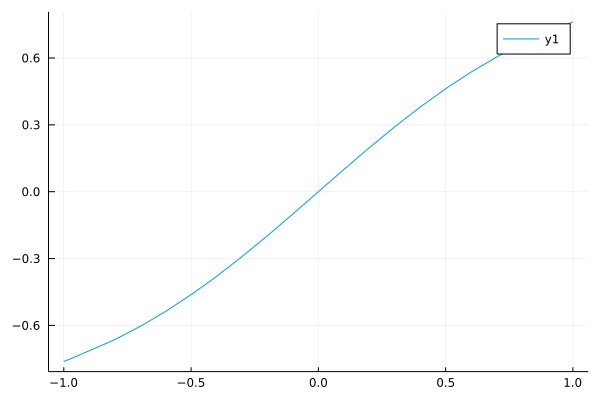

In [430]:
plot(tanh, -1, 1)

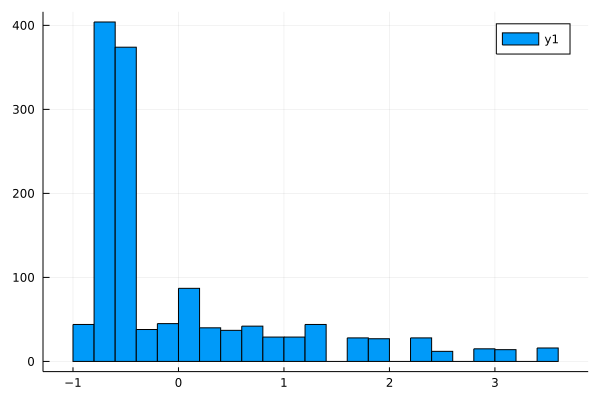

In [145]:
histogram(train_data[5,:])

In [83]:
a = zeros(6,1)
n = size(train_data, 2)
for i in 1:n
    if train_data[6,i] > 90 && train_data[6,i] < 115
      a = hcat(a, train_data[:,i]) 
    end
end
a = a[:,2:end]

6×132 Matrix{Float64}:
  -0.834152    2.23917     0.347897  …    0.66311      1.60875    -0.282529
   1.81395    -0.798769    1.50857        0.371867    -0.883597    0.999599
  -1.18465     0.983907   -0.371444      -0.371444     1.79712     0.170696
   0.29805     1.31427     1.31427       -0.724607    -0.724607   -0.724607
   0.410109   -0.619274    2.45942        0.0998668   -0.544505    3.56767
 110.491     113.086     113.298     …  113.08       112.251     109.52

In [10]:
balanced = copy(train_data)

6×1353 Matrix{Float64}:
  -0.834152   -0.597742   -0.124923  …   -0.714371    0.0799658   -0.408614
   1.81395    -1.13808    -1.13808        1.81395    -1.13808     -1.13808
  -1.18465    -0.913585   -0.371444      -1.18465     1.79712      0.983907
   0.29805     0.29805     1.31427       -1.23272    -1.23272     -0.724607
   0.410109   -0.782914   -0.749045       0.492556   -0.590419    -0.649098
 110.491     125.586     132.595     …  136.886     119.135      127.095

In [91]:
a = zeros(6,1)
n = size(balanced, 2)
for i in 1:n
    if balanced[6,i] > 95 && balanced[6,i] < 105
      a = hcat(a, balanced[:,i]) 
    end
end
a = a[:,2:end]

6×196 Matrix{Float64}:
   1.07289     1.07289     0.66311   …    1.07289     0.66311     0.347897
   0.999599    1.50857     0.999599       1.50857     0.999599    0.999599
   0.170696   -0.371444    0.170696      -0.371444    0.170696    0.170696
  -0.724607   -0.724607   -0.724607      -0.724607   -0.724607   -0.724607
   3.56767     3.14788     3.56767        3.14788     3.56767     3.56767
 103.38      104.204     104.13      …  104.204     104.13      104.5

In [92]:
for i in 1:1
    balanced = hcat(balanced, a)
end

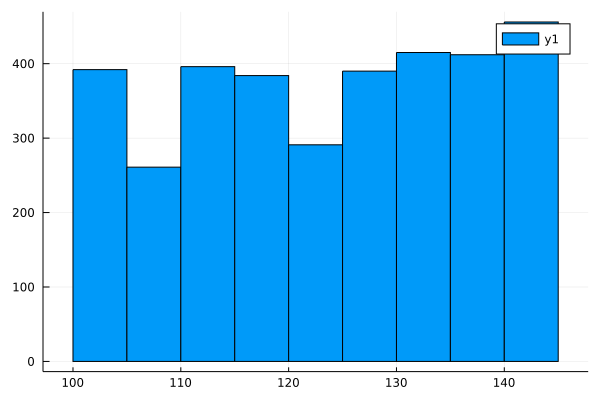

In [93]:
histogram(balanced[6,:])